### Ex 2B : Association Rule Mining - FP Growth Algorithm

* Download a market basket analysis dataset from Kaggle and implement  FP-Growth algorithms to generate strong association rules.
* Assume minimum support count = 3 and minimum confidence = 60%

In [1]:
#import libraries
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Grocery.csv", usecols=["Items"])
df.head()

,Items
0,"MILK,BREAD,BISCUIT"
1,"BREAD,MILK,BISCUIT,CORNFLAKES"
2,"BREAD,TEA,BOURNVITA"
3,"JAM,MAGGI,BREAD,MILK"
4,"MAGGI,TEA,BISCUIT"


In [3]:
df.Items = df.Items.apply(lambda x : str(x).split(","))
transactions = list(df.Items)
transactions[:5]

[['MILK', 'BREAD', 'BISCUIT'],
 ['BREAD', 'MILK', 'BISCUIT', 'CORNFLAKES'],
 ['BREAD', 'TEA', 'BOURNVITA'],
 ['JAM', 'MAGGI', 'BREAD', 'MILK'],
 ['MAGGI', 'TEA', 'BISCUIT']]

In [4]:
df_exploded = df.explode("Items")
dummies = pd.get_dummies(df_exploded, columns=["Items"])

In [5]:
basket = dummies.groupby(dummies.index).sum()
basket.reset_index(drop=True, inplace=True)

In [6]:
basket.columns = [col.replace('Items_', '') for col in basket.columns]
display(basket.head())

,BISCUIT,BOURNVITA,BREAD,COCK,COFFEE,CORNFLAKES,JAM,MAGGI,MILK,SUGAR,SUGER,TEA
0,1,0,1,0,0,0,0,0,1,0,0,0
1,1,0,1,0,0,1,0,0,1,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,1,1,1,0,0,0
4,1,0,0,0,0,0,0,1,0,0,0,1


In [7]:
frequent_itemsets = fpgrowth(basket, min_support = 3/len(basket), use_colnames=True)
len(frequent_itemsets)

/Users/anand/miniconda3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


24

In [8]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
display(rules.head())

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(MILK),(BREAD),0.238095,0.666667,0.190476,0.800000,1.200000,0.031746,1.666667,0.218750
1,(CORNFLAKES),(COFFEE),0.285714,0.428571,0.190476,0.666667,1.555556,0.068027,1.714286,0.500000
2,(TEA),(BREAD),0.380952,0.666667,0.238095,0.625000,0.937500,-0.015873,0.888889,-0.097222
3,(BOURNVITA),(BREAD),0.238095,0.666667,0.190476,0.800000,1.200000,0.031746,1.666667,0.218750
4,(BOURNVITA),(TEA),0.238095,0.380952,0.142857,0.600000,1.575000,0.052154,1.547619,0.479167


In [9]:
# Implementation of FP Growth Algorithm
from collections import defaultdict

class FPTree :
  def __init__(self, item, count, parent=None) :
    self.item = item
    self.count = count
    self.parent = parent
    self.children = defaultdict(FPTree)

def generate_fptree(transactions, min_support) :
    item_counts = dict()
    for transaction in transactions :
      for item in transaction :
        item_counts[item] = item_counts.get(item, 0) + 1
    fptree = FPTree(None, 0)
    for transaction in transactions :
      ordered_items = sorted([item for item in transaction if item_counts[item] >= min_support], key=lambda item : (-item_counts[item], item))
      current = fptree
      for item in ordered_items :
          if item not in current.children :
              current.children[item] = FPTree(item, 1, parent=current)
          current = current.children[item]
          current.count += 1
    return fptree, item_counts

def conditional_transactions(node) :
  conditional_transaction = list()
  while node is not None :
    prefix_path = list()
    current = node
    while current.parent is not None :
      prefix_path.append(current.item)
      current = current.parent
    if len(prefix_path) > 1 :
      conditional_transaction.append(prefix_path[1:])
    if len(node.children) > 0 :
      node = node.children[next(iter(node.children))]
    else :
      break
  return conditional_transaction


def generate_frequent_itemsets(fptree, item_counts, min_support, prefix=None) :
  if prefix is None :
    prefix = set()
  frequent_itemsets = list()
  for item, node in fptree.children.items() :
    support = item_counts[item]
    if support >= min_support and len(node.children) > 0:
      new_prefix = prefix.copy()
      new_prefix.add(item)
      frequent_itemsets.append((new_prefix, support))
      conditional_fptree, conditional_itemcounts = generate_fptree(conditional_transactions(node), min_support)
      print(node.item, len(conditional_fptree.children))
      frequent_itemsets.extend(generate_frequent_itemsets(conditional_fptree, conditional_itemcounts, min_support, new_prefix))
  return frequent_itemsets

def fpgrowth(transactions, min_support=2) :
  fptree, item_counts = generate_fptree(transactions, min_support)
  frequent_itemsets = generate_frequent_itemsets(fptree, item_counts, min_support)
  return frequent_itemsets

frequent_itemsets = fpgrowth(transactions, 3)

BREAD 0
TEA 0
COFFEE 1


In [10]:
ans = list()
for item in frequent_itemsets :
  ans.append({"Item" : item[0], "Support" : item[1]/len(transactions)})
frequent_itemsets = pd.DataFrame(ans)
display(frequent_itemsets)

,Item,Support
0,{BREAD},0.666667
1,{TEA},0.380952
2,{COFFEE},0.428571


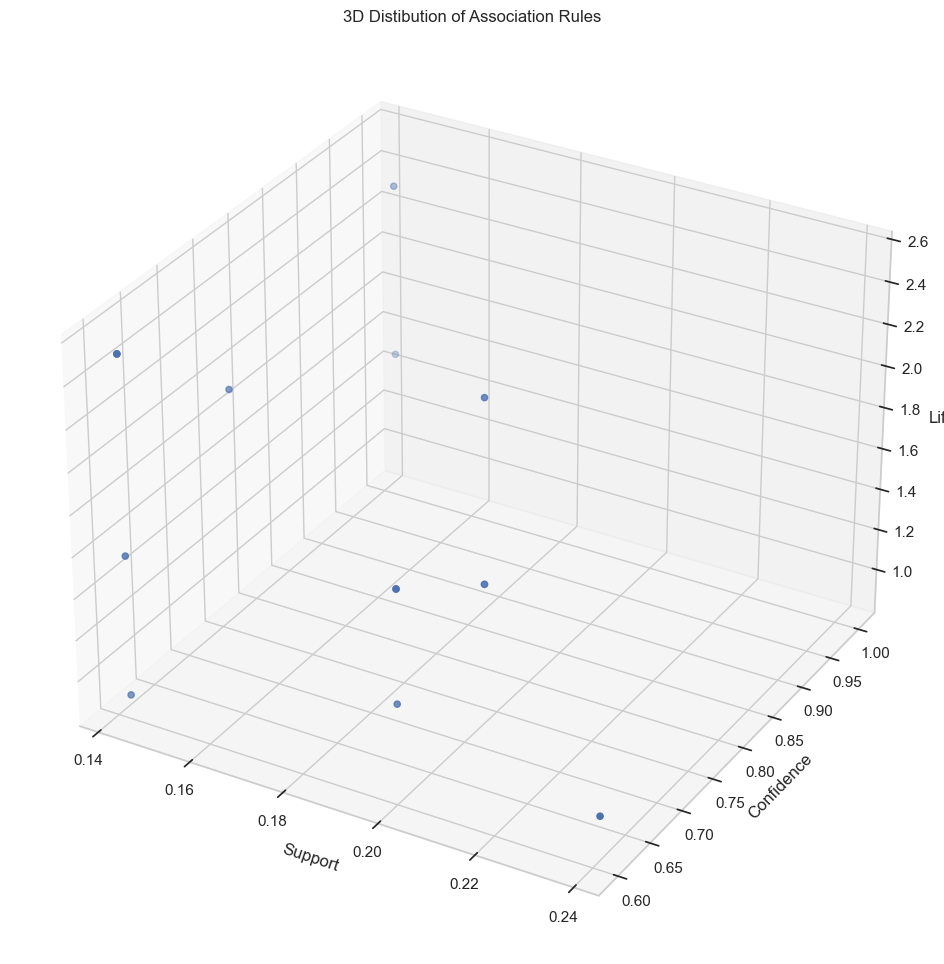

In [11]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
x = rules['support']
y = rules['confidence']
z = rules['lift']
ax.set_xlabel('Support')
ax.set_ylabel('Confidence')
ax.set_zlabel('Lift')
ax.scatter(x,y,z)
ax.set_title('3D Distibution of Association Rules')
plt.show()
#Note : Rules at top right are more meaningful